In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns

sns.set()

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種を固定（再現性を確保）
np.random.seed(1)

# シミュレーションするデータの長さを指定
sim_size = 100

# 正規分布に従う乱数を生成し、その累積和を取る
# → 各時点の値が「前の時点の値＋ランダム誤差」で決まるランダムウォーク過程を作成
mu_cumsum = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))

# 結果として mu_cumsum は、次の式で表される：
# μ_t = μ_{t-1} + ε_t,   ε_t ~ N(0, 1)

In [4]:
# 乱数の種を固定（再現性の確保）
np.random.seed(1)

# シミュレーションするデータ数
sim_size = 100

# ランダムウォーク系列を格納する配列を初期化
mu_for = np.zeros(sim_size)

# 初期値（t = 0）を標準正規分布から生成
mu_for[0] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# 各時点 t における値を再帰的に生成
# y_t = y_{t-1} + ε_t  （ε_t ~ N(0, 1)）
for t in range(1, sim_size):
    mu_for[t] = mu_for[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

In [5]:
# 結果の比較：2通りの生成方法で同一のランダムウォークを作成できたか確認
all(mu_cumsum == mu_for)

True

In [6]:
# --------------------------------------------
# 乱数の種設定（再現性の確保）
# --------------------------------------------
np.random.seed(1)

# --------------------------------------------
# シミュレーション設定
# --------------------------------------------
# 観測数（サンプルサイズ）
sim_size = 100

# --------------------------------------------
# ドリフト成分（Δ_t）の初期化
# --------------------------------------------
# Δ_t ~ N(0, 1) と仮定するランダムウォーク的ドリフト
# 初期値 Δ_0 = 0 とし、1期目のみ乱数を代入
delta = np.zeros(sim_size)
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# --------------------------------------------
# 水準成分（μ_t）の初期化
# --------------------------------------------
# μ_t = μ_{t-1} + Δ_t + ε_t の形を後で構築するため、
# ここでは μ_t の格納配列をゼロで初期化
mu_smooth = np.zeros(sim_size)

In [7]:
# --------------------------------------------
# ローカル線形トレンドモデルのシミュレーション
# --------------------------------------------
# モデル構造：
#   y_t = μ_t + ε_t
#   μ_t = μ_{t-1} + δ_{t-1}
#   δ_t = δ_{t-1} + η_t
#   ε_t ~ N(0, σ_ε²), η_t ~ N(0, σ_η²)
# --------------------------------------------

for t in range(2, sim_size):
    # ドリフト（傾き）成分の更新： δ_t = δ_{t-1} + η_t
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

    # 水準（レベル）成分の更新： μ_t = μ_{t-1} + δ_{t-1}
    mu_smooth[t] = mu_smooth[t - 1] + delta[t - 1]

# --------------------------------------------
# 観測値の生成： y_t = μ_t + ε_t
# --------------------------------------------
# 観測ノイズの分散 σ_ε² = 15² として、観測系列 y_t を生成
y_smooth = mu_smooth + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [8]:
# --------------------------------------------
# シミュレーション結果を DataFrame にまとめる
# --------------------------------------------
#   - delta: トレンドの傾き（slope） δ_t
#   - mu:    水準（level） μ_t
#   - y:     観測値（observation） y_t = μ_t + ε_t
#   - index: 日付（月次データとして2000年1月から）
# --------------------------------------------

smooth_df = pd.DataFrame(
    {"delta": delta, "mu": mu_smooth, "y": y_smooth},
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="MS"),
)

# 結果の確認（先頭3行）
print(smooth_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000  10.470481
2000-02-01  1.624345  0.000000  -6.706928
2000-03-01  1.012589  1.624345  19.991961


<Axes: >

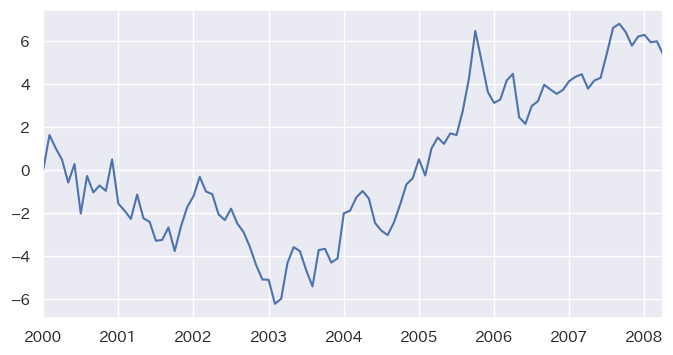

In [9]:
# --------------------------------------------
# ドリフト成分（傾き δ_t）の可視化
# --------------------------------------------
# ここでは、局所線形トレンドモデルにおける
# 「傾き（トレンドの変化率）」を表す δ_t をプロットしている。
# δ_t は状態方程式：
#   δ_t = δ_{t-1} + η_t,    η_t ~ N(0, σ_η²)
# に従うため、ゆるやかに変動するトレンドの滑らかさを可視化できる。
# --------------------------------------------

smooth_df["delta"].plot()

<Axes: >

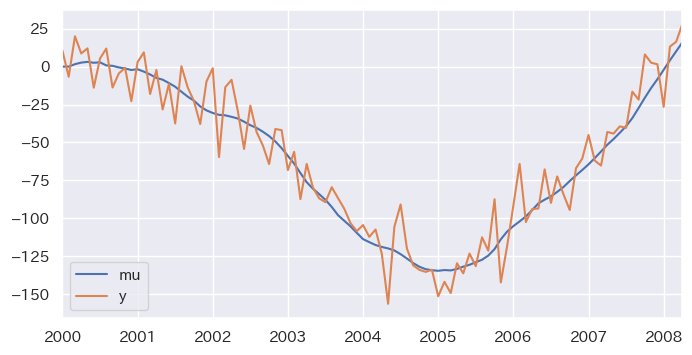

In [10]:
# --------------------------------------------
# 水準成分（μ_t）と観測値（y_t）の可視化
# --------------------------------------------
# μ_t は系列の「基調的な水準（trend level）」を表す潜在変数。
# 局所線形トレンドモデルにおける状態方程式：
#     μ_t = μ_{t-1} + δ_{t-1}
# により、ゆるやかに変化するトレンドを形成する。
#
# 一方、y_t は観測値であり、観測方程式：
#     y_t = μ_t + ε_t,   ε_t ~ N(0, σ_ε²)
# に従って、μ_t の周りにノイズとして分布する。
#
# このグラフでは、観測値 y_t（青線）と真の水準成分 μ_t（オレンジ線）
# を重ねて描画することで、観測ノイズによる揺らぎと
# 真のトレンドの滑らかさを対比的に確認できる。
# --------------------------------------------

smooth_df[["mu", "y"]].plot()

In [11]:
# --------------------------------------------------------
# 水準成分 μ_t は「正規ホワイトノイズの2階累積和」として表せる
# --------------------------------------------------------
# 局所線形トレンドモデル（Local Linear Trend Model）では：
#
#     μ_t = μ_{t-1} + δ_{t-1}
#     δ_t = δ_{t-1} + η_t,   η_t ~ N(0, σ_η²)
#
# したがって、δ_t はホワイトノイズ η_t の累積和、
# μ_t はそのさらに累積和、すなわち「2階累積和」となる。
#
# 言い換えれば、μ_t は「2階の積分過程」に相当し、
# 差分を2回とると定常系列になる（＝2階差分過程）。
#
# このことが、「局所線形トレンドモデルは 2階差分に由来する」
# といわれる理由である。
# --------------------------------------------------------

np.random.seed(1)
cumsum2 = np.cumsum(np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size)))

all(cumsum2[0:98] == mu_smooth[2:])

True